# Trabajo de Mentoria - DiploDatos

**Grupo A**
    
Integrantes: 
    <li> Bruno Garcia
    <li> Nicolas Chiapello
    <li> Martin Peñas
    <li> Pame Pairo

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import missingno as msno

plt.rcParams['font.family'] = 'Tahoma'
sns.set_context('talk')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Bruno:
df_news= pd.read_csv("sentPositiveall-data.csv", names=["feeling", "news"])

In [3]:
df_news.head(10)

,feeling,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


### *Analizamos datos faltantes*

Previo a trabajar con las consignas dadas, observamos si tenemos datos faltantes dentro de las columnas, pero no es el caso.



<AxesSubplot:>

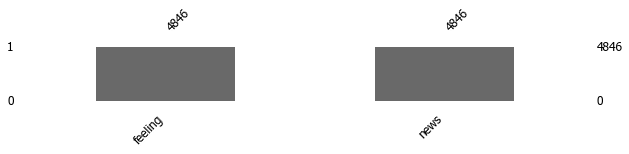

In [4]:
msno.bar(df_news, figsize=(10,1), fontsize=12)

### *Analizamos noticias repetidas*

In [5]:
df_news.news.value_counts().head(10)

Ahlstrom 's share is quoted on the NASDAQ OMX Helsinki .                                                                                                                                                                                                                                                    2
The company serves customers in various industries , including process and resources , industrial machinery , architecture , building , construction , electrical , transportation , electronics , chemical , petrochemical , energy , and information technology , as well as catering and households .    2
Proha Plc ( Euronext :7327 ) announced today ( 19 May ) that its fully-owned subsidiary , Safran Software Solutions AS , has agreed to sell its 49 % share of Safran North America LLC to a SNA Holding AS , an investment group based in Norway .                                                          2
The issuer is solely responsible for the content of this announcement .                       

In [6]:
df_news.news.size

4846

In [7]:
df_news = df_news.drop_duplicates(subset = ["news"])

In [8]:
df_news.news.size

4838

### *Control*

In [9]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4838 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feeling  4838 non-null   object
 1   news     4838 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


In [10]:
df_news.describe()

,feeling,news
count,4838,4838
unique,3,4838
top,neutral,This new partnership agreement represents a si...
freq,2872,1


## *Analisis y curación*

#### Word tokenizer

Generamos los tokens a partir de los espacios en blanco y a partir de los saltos de línea "\n".

In [11]:
from nltk.tokenize import WhitespaceTokenizer

#Generamos los tokens a partir de espacios en blanco y de saltos de línea
def p_word_tokenizer(text_string):    
    return WhitespaceTokenizer().tokenize(text_string)

#### Only letters

Pasamos palabras a minúsculas, removemos símbolos y números. Removemos todos los símbolos y números ya que observamos luego de no haberlos sacado en un comienzo que estos caracteres solo terminaban generando ruido, y no aportando información relevante para nuestro análisis.

In [12]:
import re

#Pasamos palabras a minúsculas, removemos símbolos y números
def p_only_letters(text_list):

    #Pasa todo a minúscula y remueve todos los símbolos excepto el guión bajo
    clean_text_list = [re.sub('[\W]+', '', word.lower()) for word in text_list]

    #Remueve números
    clean_text_list = [re.sub(r"\d+", "", word) for word in clean_text_list]

    #Elimina los tokens vacíos
    for i in range(clean_text_list.count('')):
        clean_text_list.remove('')

    return clean_text_list

#### Remove stopwords

In [16]:
import nltk.corpus
from nltk.corpus import stopwords
#nltk.download('stopwords')

#Eliminamos stopwords
def p_remove_stopwords(text_list):
    stop = stopwords.words('english')
    return [word for word in text_list if word not in (stop)]

#### Word lemmatizer

El proceso de lematizado tiene por objetivo reducir las palabras de su forma flexionada (ej: comiendo, amigos) a su forma raíz (comer, amigo).

Aquí lemmatizamos para todos los tipos de palabras: verbo, sustantivo, adjetivo y adverbio. Por defecto el método lo hace solo para sustantivos (pos="n") por eso por ejemplo no transforma verbos como raining a rain, y si no se aplica de esta forma hay muchas palabras que siguen quedando en su forma flexionada; por ello, lo realizamos de esta forma.

In [17]:
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

#Lemmatizamos para todos los tipos de palabras: verbo, sustantivo, adjetivo y adverbio.
def p_word_lemmatizer(text_list):
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="n") for word in text_list]
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="v") for word in lemm_text_list]
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="a") for word in lemm_text_list]
    lemm_text_list = [WordNetLemmatizer().lemmatize(word, pos="r") for word in lemm_text_list]
    return lemm_text_list

#### Pipeline

Realizamos una función de transformación para "pipelinizar" aquellas funciones que se usarán en el pipeline:

In [18]:
from sklearn.preprocessing import FunctionTransformer

#Función para transformar las funciones que se usarán en el pipeline.
def pipelinize(function, active=True):

    def list_comprehend_a_function(list_of_texts, active=True):
        if active:
            return [function(i) for i in list_of_texts]
        else: # if it's not active, just pass it right back
            return list_of_texts

    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

Aquí utilizamos por primera vez el pipeline para aplicar las funciones de normalización en cada noticia de esta forma más automatizada:

In [19]:
from sklearn.pipeline import Pipeline

estimators = [('p_word_tokenizer', pipelinize(p_word_tokenizer)),
              ('p_only_letters', pipelinize(p_only_letters)),
              ('p_remove_stopwords', pipelinize(p_remove_stopwords)),
              ('p_word_lemmatizer', pipelinize(p_word_lemmatizer))]
pipe = Pipeline(estimators)

df_news['news_tokens'] = pipe.transform(df_news.news)

In [20]:
df_news[:10]

,feeling,news,news_tokens
0,neutral,"According to Gran , the company has no plans t...","[accord, gran, company, plan, move, production..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plan, develop, stage, area, le, ..."
2,negative,The international electronic industry company ...,"[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,"[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,"[accord, company, update, strategy, year, basw..."
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,"[finance, aspocomp, growth, aspocomp, aggressi..."
6,positive,"For the last quarter of 2010 , Componenta 's n...","[last, quarter, componenta, net, sale, double,..."
7,positive,"In the third quarter of 2010 , net sales incre...","[third, quarter, net, sale, increase, eur, mn,..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...,"[operate, profit, rise, eur, mn, eur, mn, corr..."
9,positive,"Operating profit totalled EUR 21.1 mn , up fro...","[operate, profit, total, eur, mn, eur, mn, rep..."


#### Etiquetamos Part of Speech

Por último realizamos un etiquetado Part of Speech que consiste en categorizar las palabras lingüísticamente.

In [21]:
#nltk.download('averaged_perceptron_tagger')

def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

In [22]:
df_news['news_tokens_tagged'] = df_news['news_tokens'].apply(lambda x: word_pos_tagger(x))
df_news[:5]

,feeling,news,news_tokens,news_tokens_tagged
0,neutral,"According to Gran , the company has no plans t...","[accord, gran, company, plan, move, production...","[(accord, NN), (gran, VBD), (company, NN), (pl..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plan, develop, stage, area, le, ...","[(technopolis, NN), (plan, NN), (develop, VBP)..."
2,negative,The international electronic industry company ...,"[international, electronic, industry, company,...","[(international, JJ), (electronic, JJ), (indus..."
3,positive,With the new production plant the company woul...,"[new, production, plant, company, would, incre...","[(new, JJ), (production, NN), (plant, NN), (co..."
4,positive,According to the company 's updated strategy f...,"[accord, company, update, strategy, year, basw...","[(accord, NN), (company, NN), (update, NN), (s..."


In [23]:
df_news.to_csv("C:/Users/Pame/OneDrive - ege.fcen.uba.ar/Diplo/mentoria/feeling_procesado.csv")